# Eigenschaften der Fälle in der HACI-Datenbank

Nachdem die Objektdefinition und das Objekttracking funktionieren, können wir uns die Eigenschaften der Fälle ansehen.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from standard_config import *

import sys
sys.path.append("{}/utils/io".format(local_home_path))
import file_io as fio
import io_config as ioc

sys.path.append("{}/utils/tracking".format(local_home_path))
import object_tracking as ot
import segmentation as oseg

import glob

import tqdm
import seaborn as sns

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def plot_haci_case(case_data):
    from plotting_tools.colormaps import enhanced_colormap2
    emap = enhanced_colormap2()
    
    from plotting_tools.colormaps import radar_cmap as rc
    
    fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
    axs = ax.ravel()

    for i,ir in enumerate(case_data['ir108']):
        p = axs[i].pcolormesh(case_data['slon'],case_data['slat'],ir,vmin=210,vmax=300,cmap=emap)
        p1 = axs[i].contourf(case_data['rlon'],
                             case_data['rlat'],
                             np.ma.masked_greater(np.ma.masked_less(case_data['rx'][i],5),70),
                             np.arange(5,75,5),
                             vmin=5,vmax=70,cmap=rc(),
                             alpha=0.5)
        
        axs[i].set_title("{}\n t = {} min".format(np.datetime_as_string(case_data['time'][i],
                                                                       unit='m',
                                                                       timezone='UTC'),
                                         (i*5) - 30))

    cbar1 = fig.colorbar(p1, ax=ax.flat,orientation='horizontal')
    cbar1.ax.set_title(u'RX / dBZ')

    cbar = fig.colorbar(p, ax=ax.flat)
    cbar.ax.set_title(r'$T_\mathrm{B}$(10.8 µm) / K')
    
    fig.delaxes(axs[13])
    fig.delaxes(axs[14])
    fig.delaxes(axs[15])
                         
    return fig 

def plot_case_object(case_data,object_data):
        
    fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
    axs = ax.ravel()

    for i,ir in enumerate(case_data['ir108']):
        p = axs[i].imshow(ir,vmin=210,vmax=300,cmap='gray_r')
        p1 = axs[i].imshow(np.ma.masked_less(object_data[i],1),
                           alpha=0.6,vmin=1,vmax=np.max(object_data),cmap='nipy_spectral')
        
        axs[i].set_title("{}\n t = {} min".format(np.datetime_as_string(case_data['time'][i],
                                                                        unit='m',
                                                                        timezone='UTC'),
                                                  (i*5) - 30)
                                                 )
    cbar1 = fig.colorbar(p1, ax=ax.flat,orientation='horizontal')
    cbar1.ax.set_title(u'Objektnummer')

    cbar = fig.colorbar(p, ax=ax.flat)
    cbar.ax.set_title(r'$T_\mathrm{B}$(10.8 µm) / K')
    
    fig.delaxes(axs[13])
    fig.delaxes(axs[14])
    fig.delaxes(axs[15])
                         
    return fig  

Um das ganze erstmal übersichtlich zu gestalten, sehen wir uns nur die Fälle eines Falltages an, des 18.&thinsp;06.&thinsp;2012.

In [3]:
haci_cases = glob.glob("{}/track_20120618*.nc".format(ioc.haci_track_data_path))

In [4]:
haci_cases

['/vols/satellite/home/lenk/data/HACI_track_data/track_20120618_460.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20120618_5675.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20120618_6723.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20120618_6247.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20120618_6949.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20120618_7038.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20120618_5994.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20120618_5876.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20120618_6046.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20120618_6893.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20120618_4731.nc',
 '/vols/satellite/home/lenk/data/HACI_track_data/track_20120618_2643.nc']

In [5]:
case_data = dict()

for hc in haci_cases:
    track_id = fio.extract_track_id_from_file_name(hc)
    
    data = fio.read_nc_file(hc)
    
    case_data[track_id] = data

Dann sehen wir uns die Fälle mal an, um einen Überblick zu bekommen.

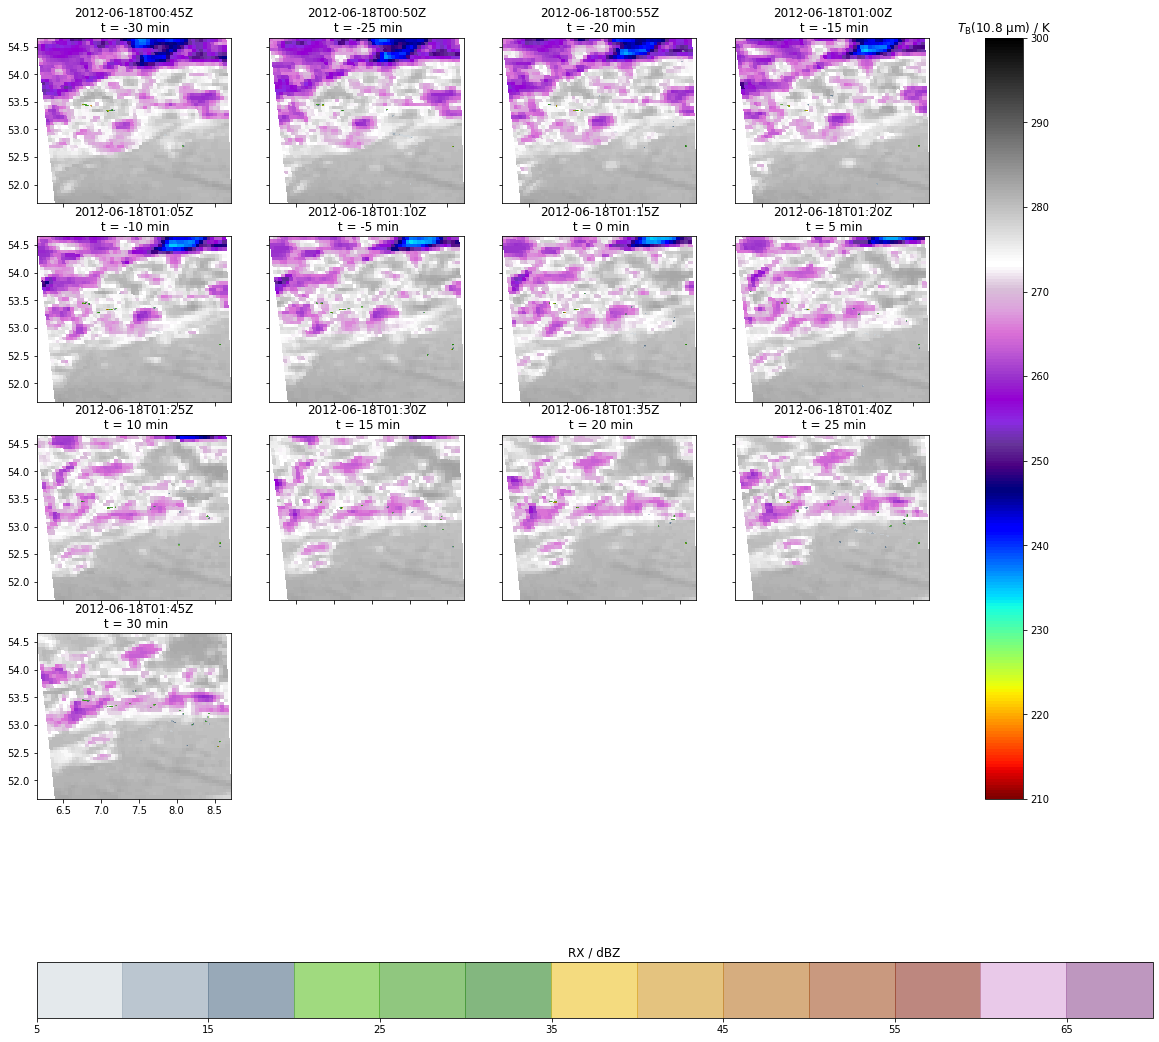

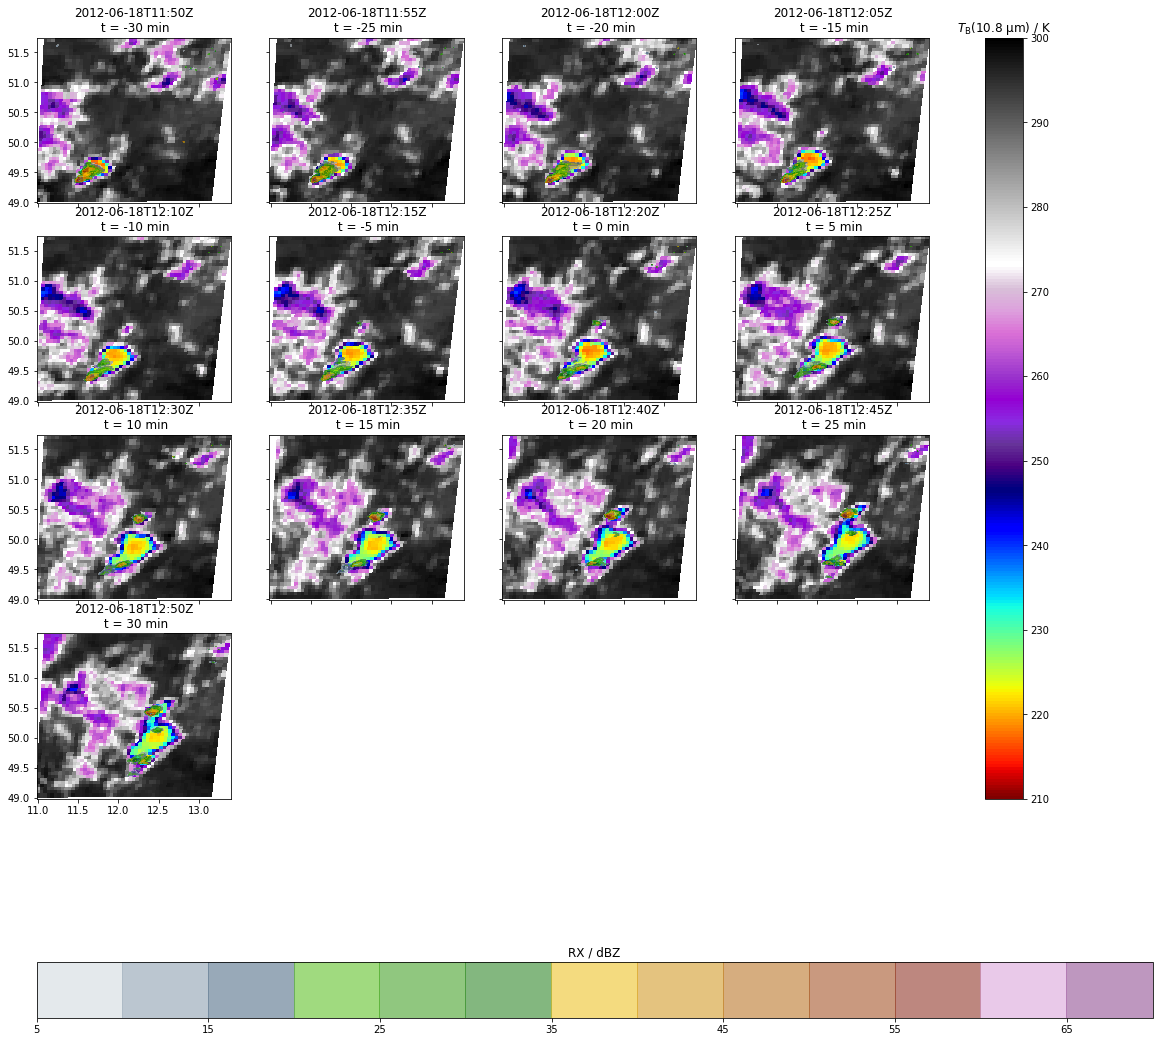

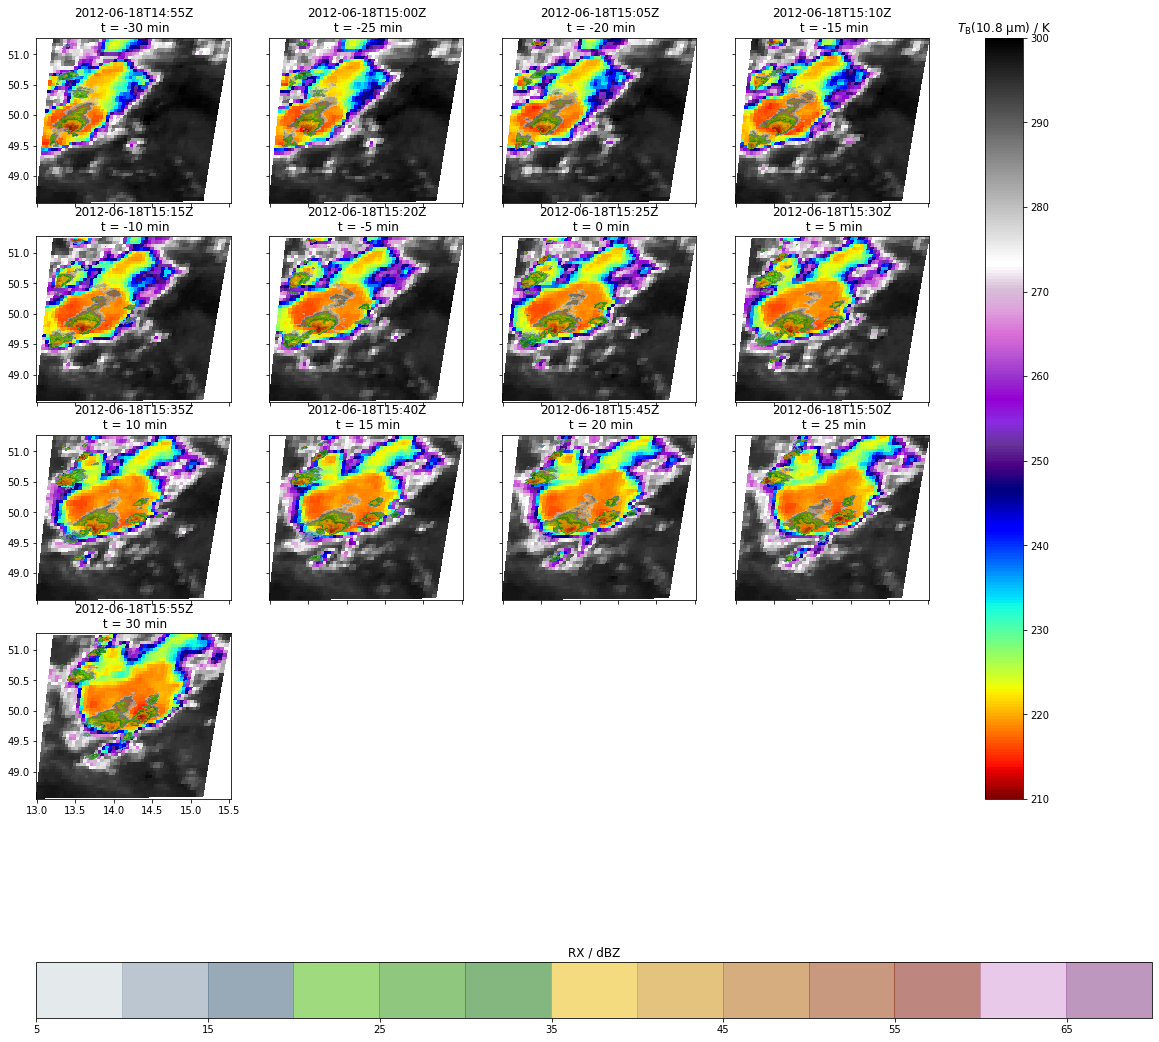

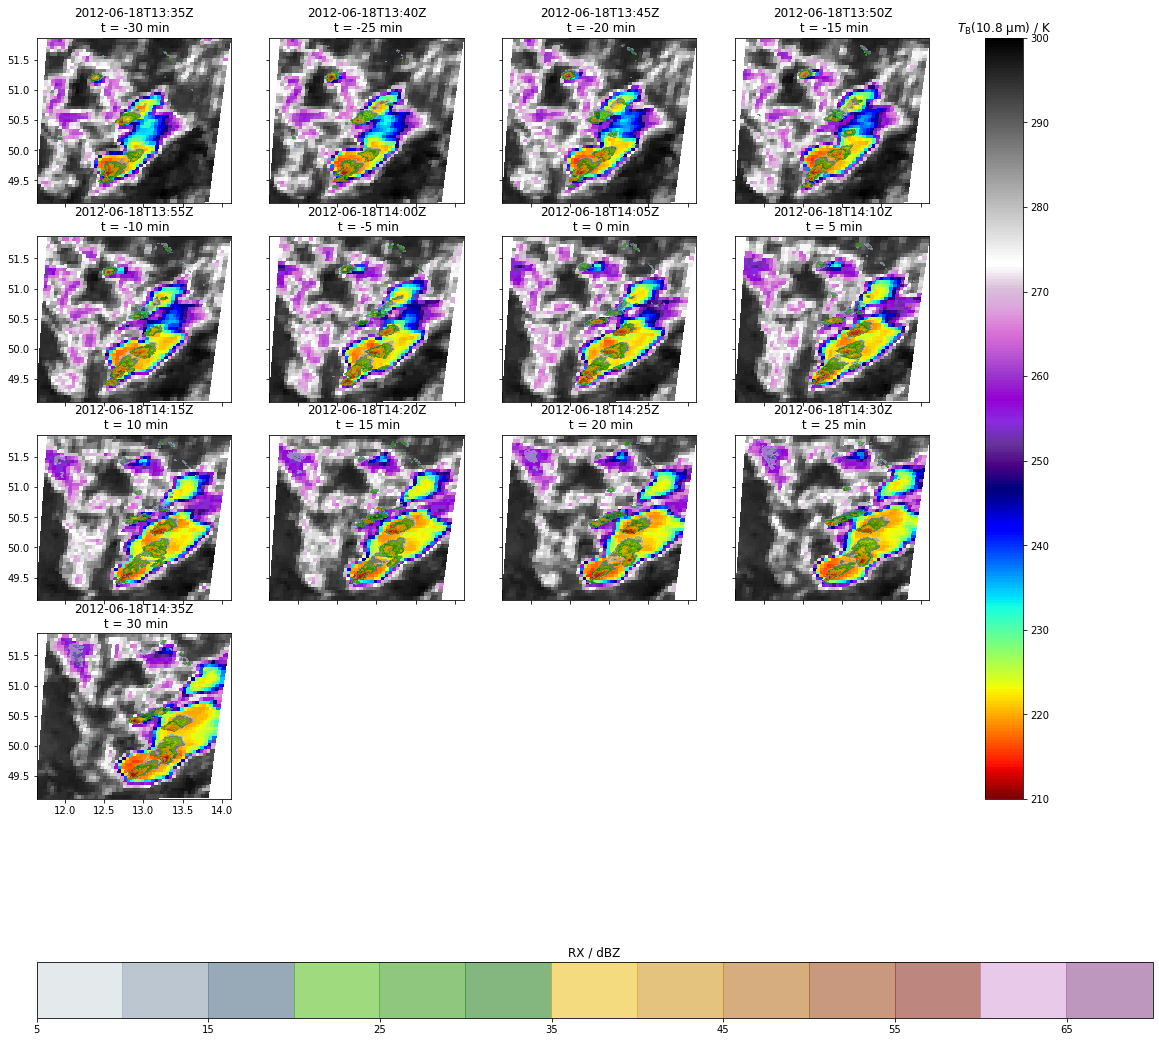

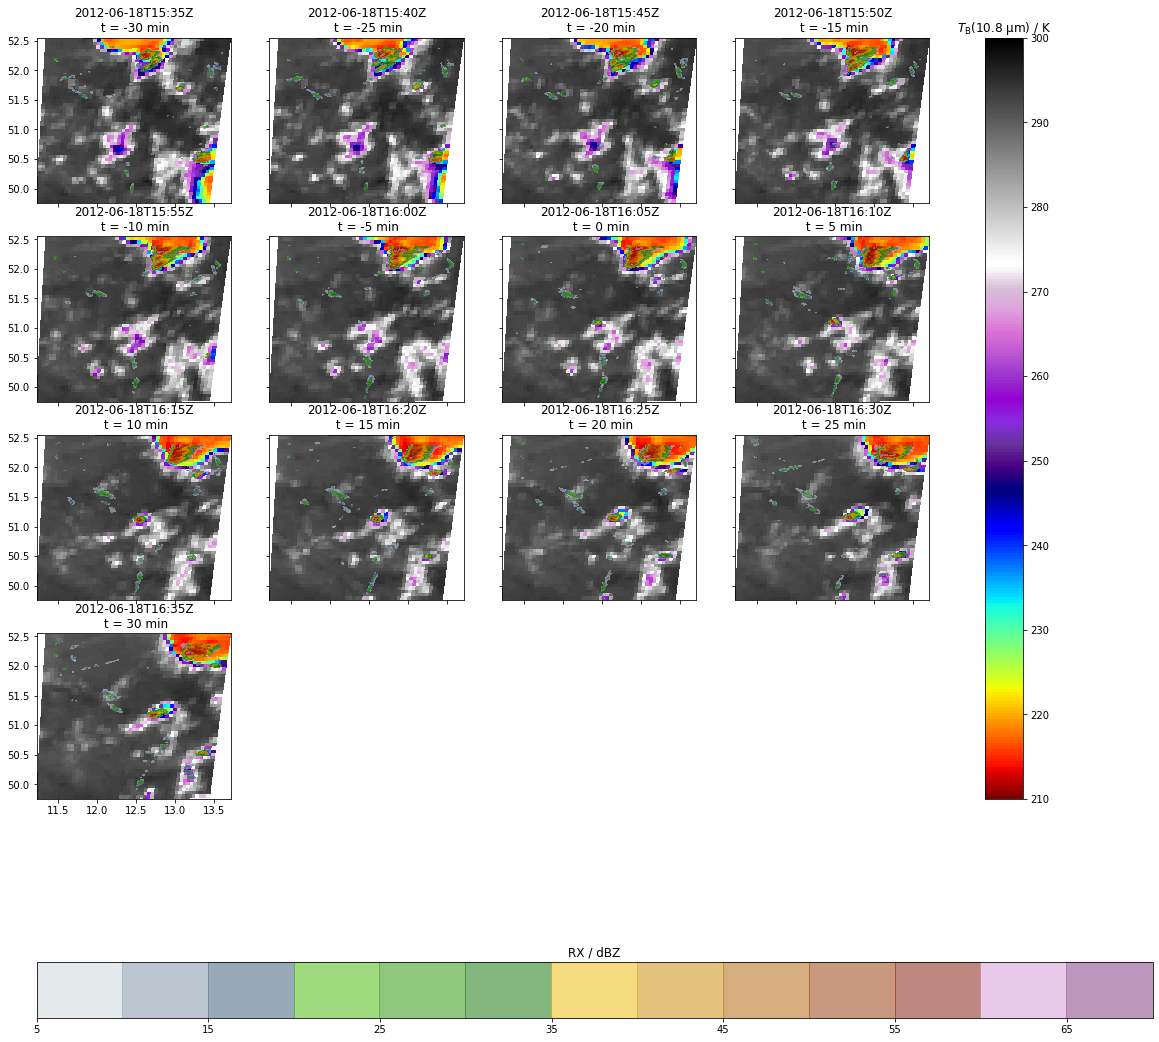

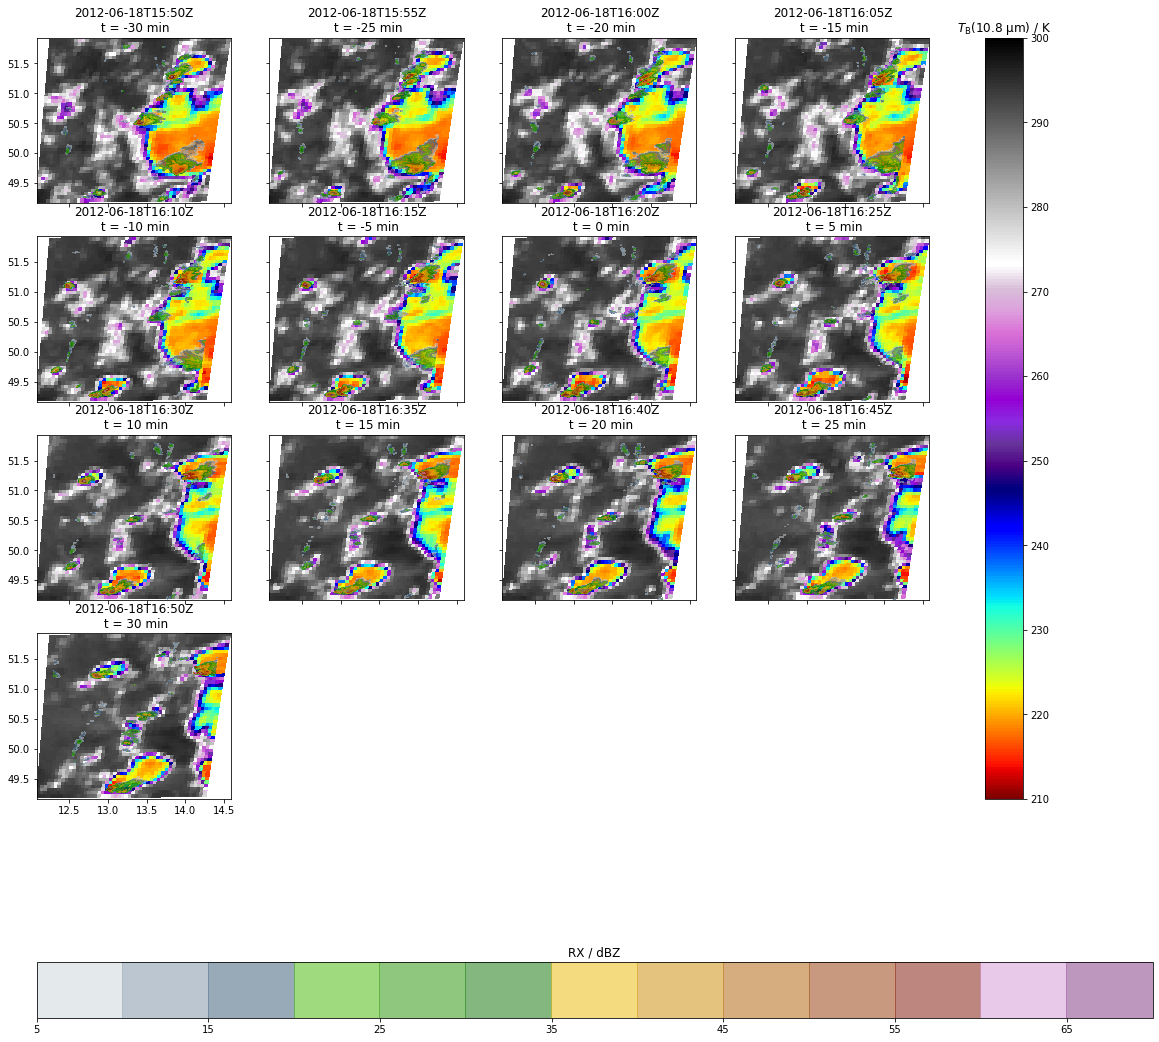

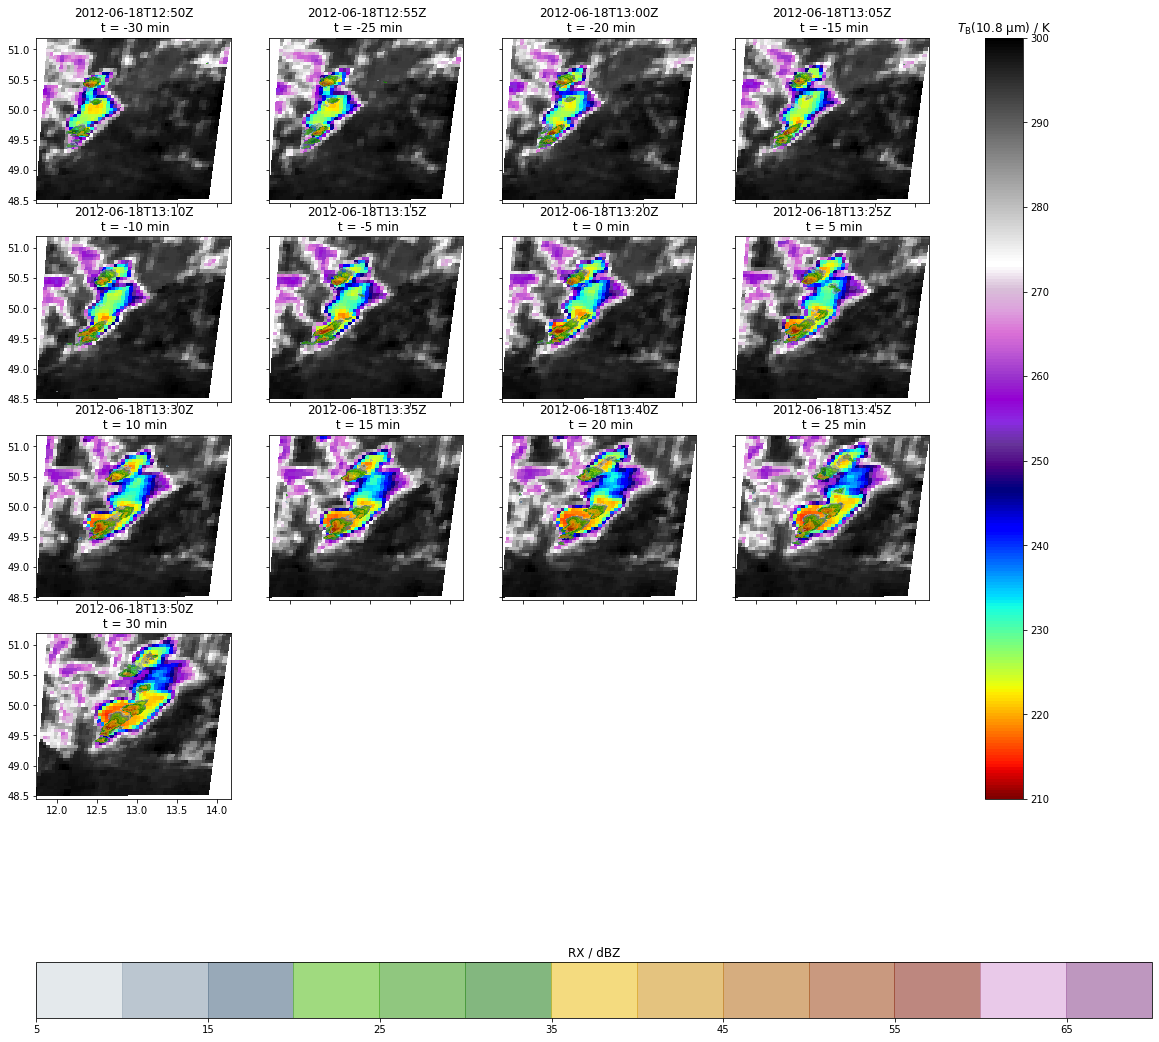

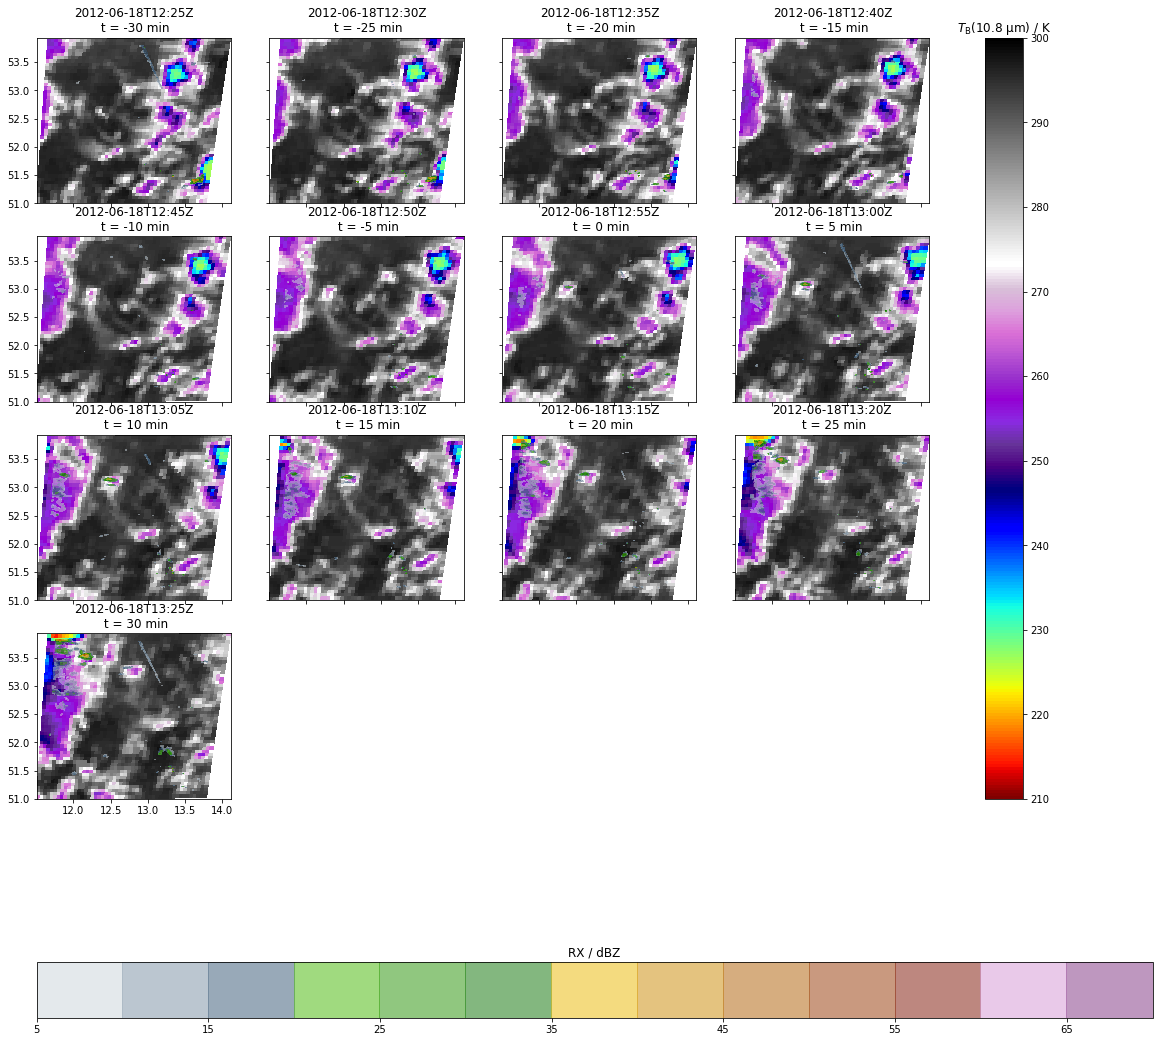

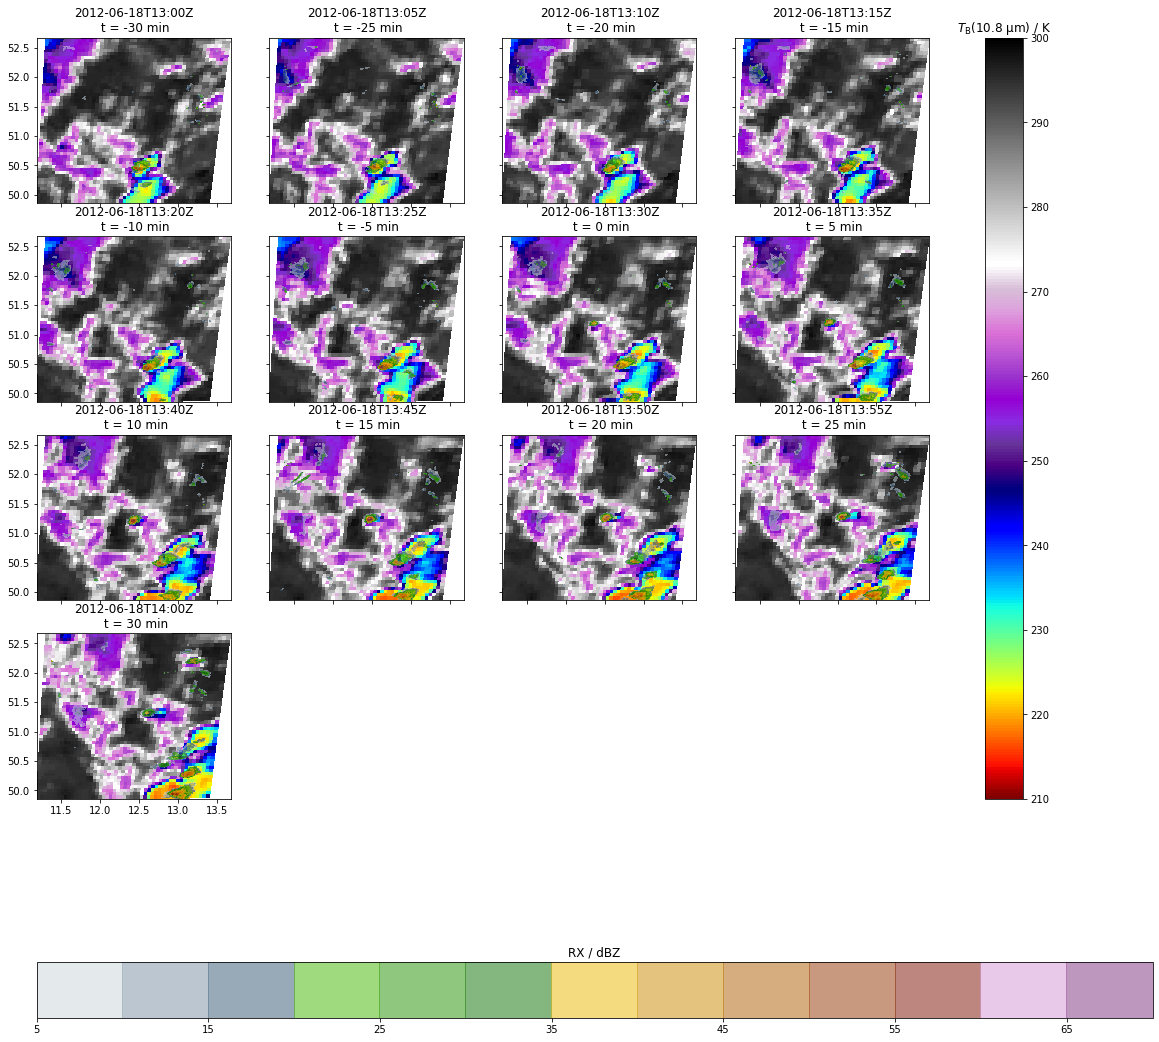

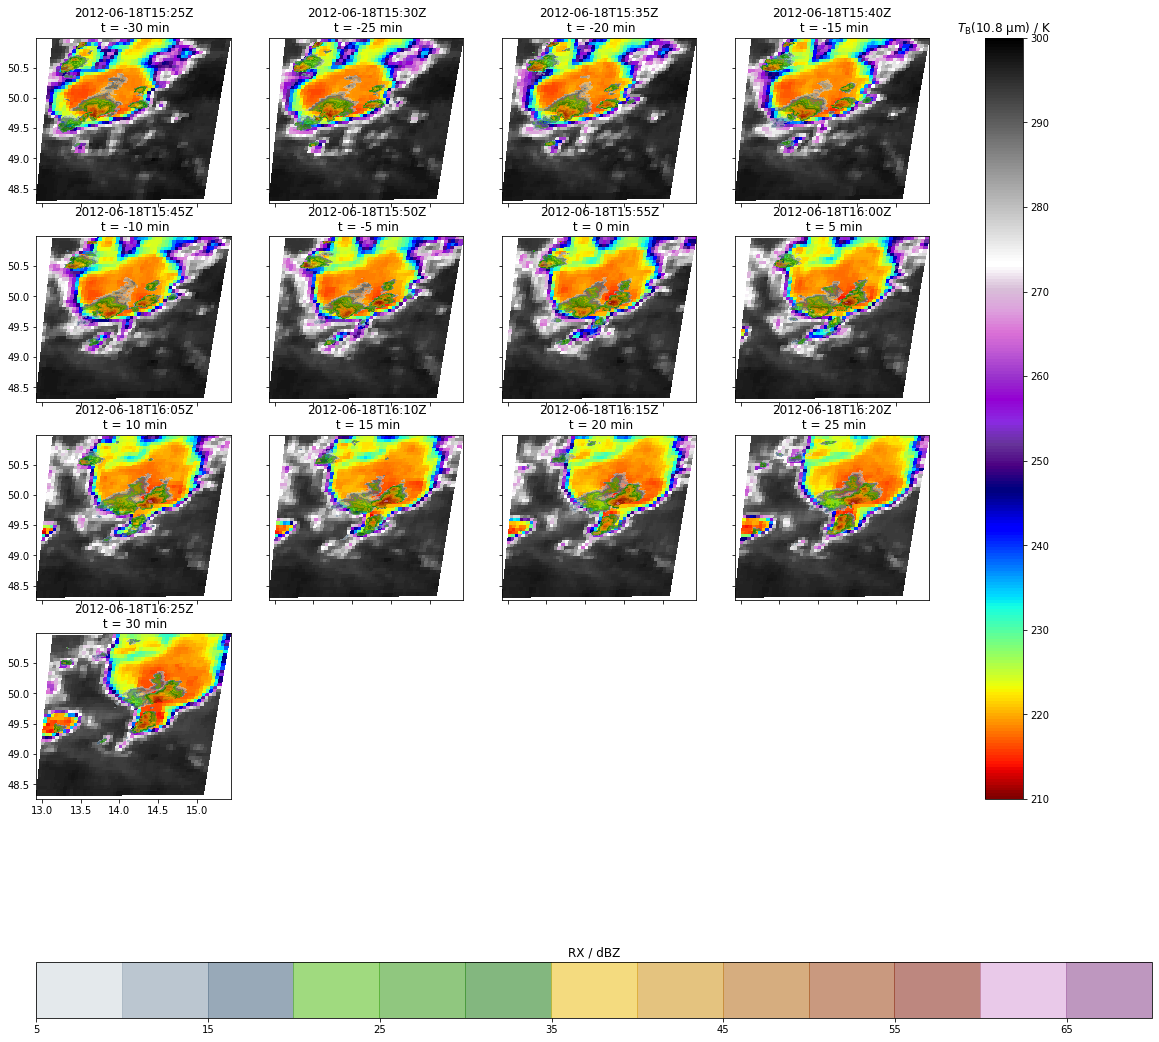

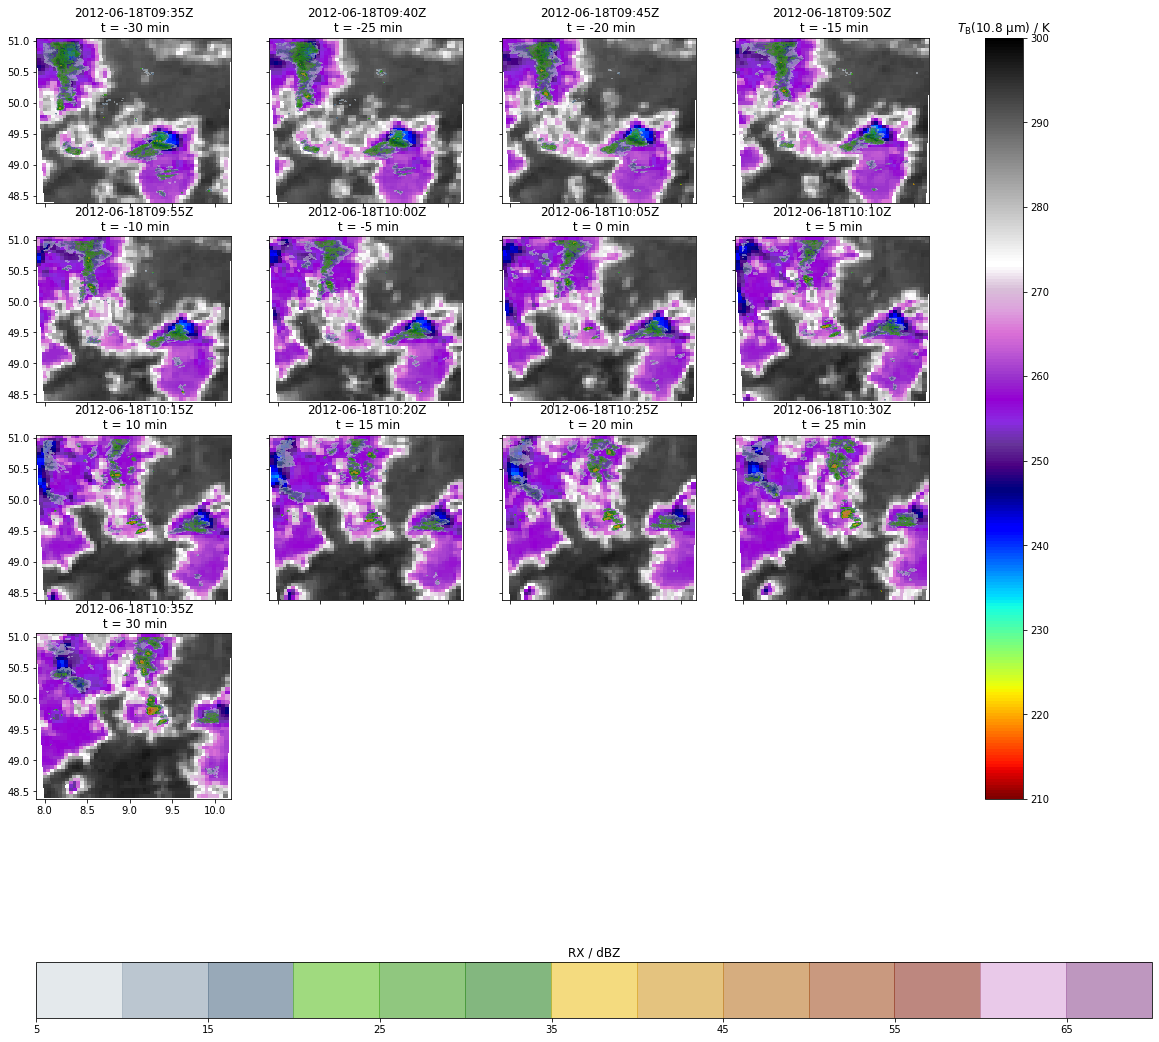

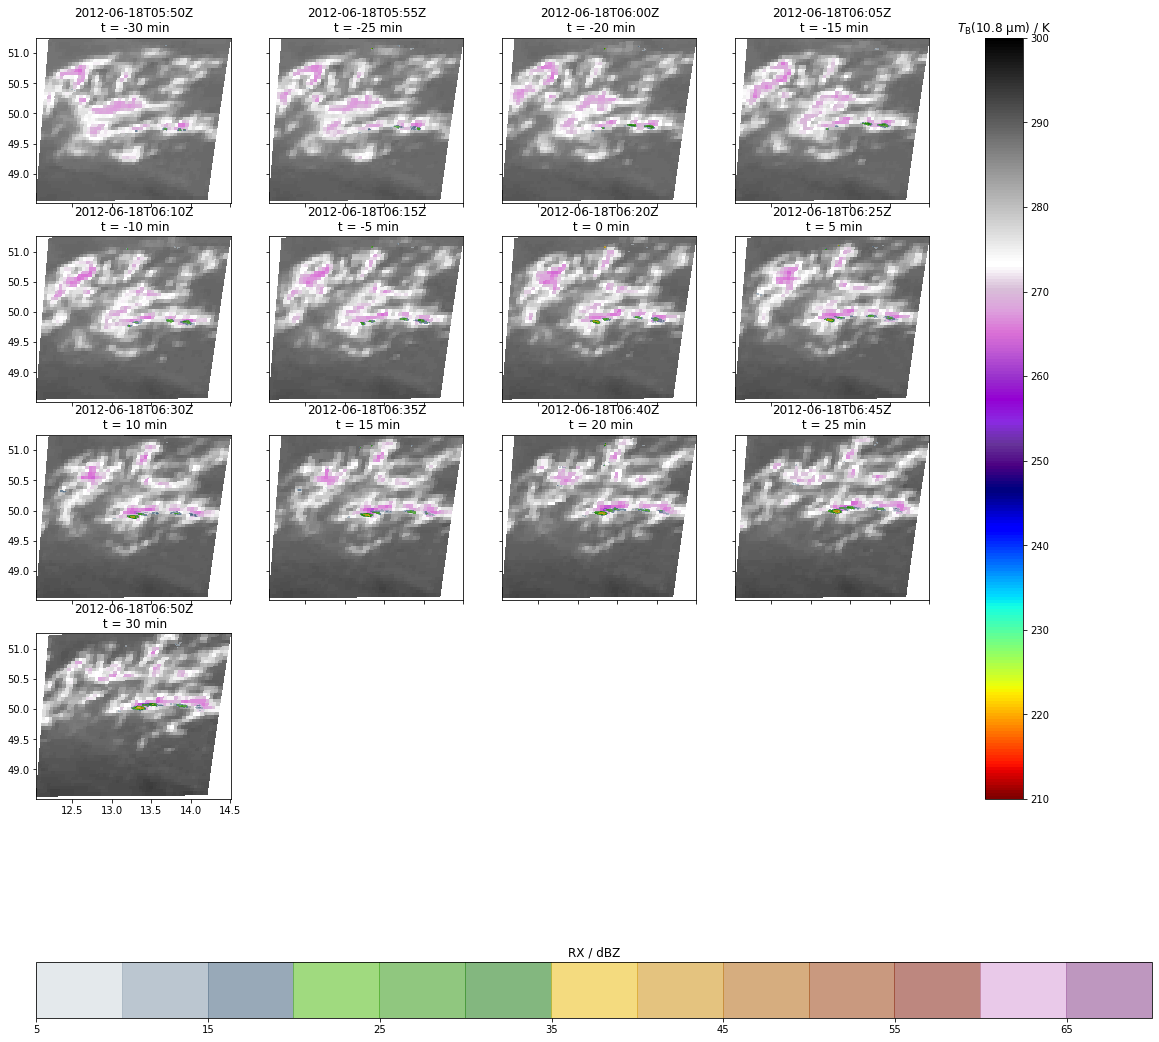

In [6]:
for track_id in case_data.keys():
    fig = plot_haci_case(case_data[track_id])

Hier ist eigentlich bereits alles dabei: gut isolierte Fälle, Fälle in Wolkenfelder und Fälle unter hohen Wolken. Mal sehen, ob wir für all diese Fälle sinnvolle Eigenschaften ableiten können.

Dafür sehen wir uns zunächste einen Beispielfall an.

In [7]:
case = case_data[list(case_data.keys())[1]]

In [8]:
case_objects, case_tracks = ot.track_objects_lmin_cost(case,'ir108','wv073',minimum_depth=4,
                                                       tmin=220,tmax=273.15,tlevel=240,
                                                       spread=5,search_factor=3,smoothing_factor=1)

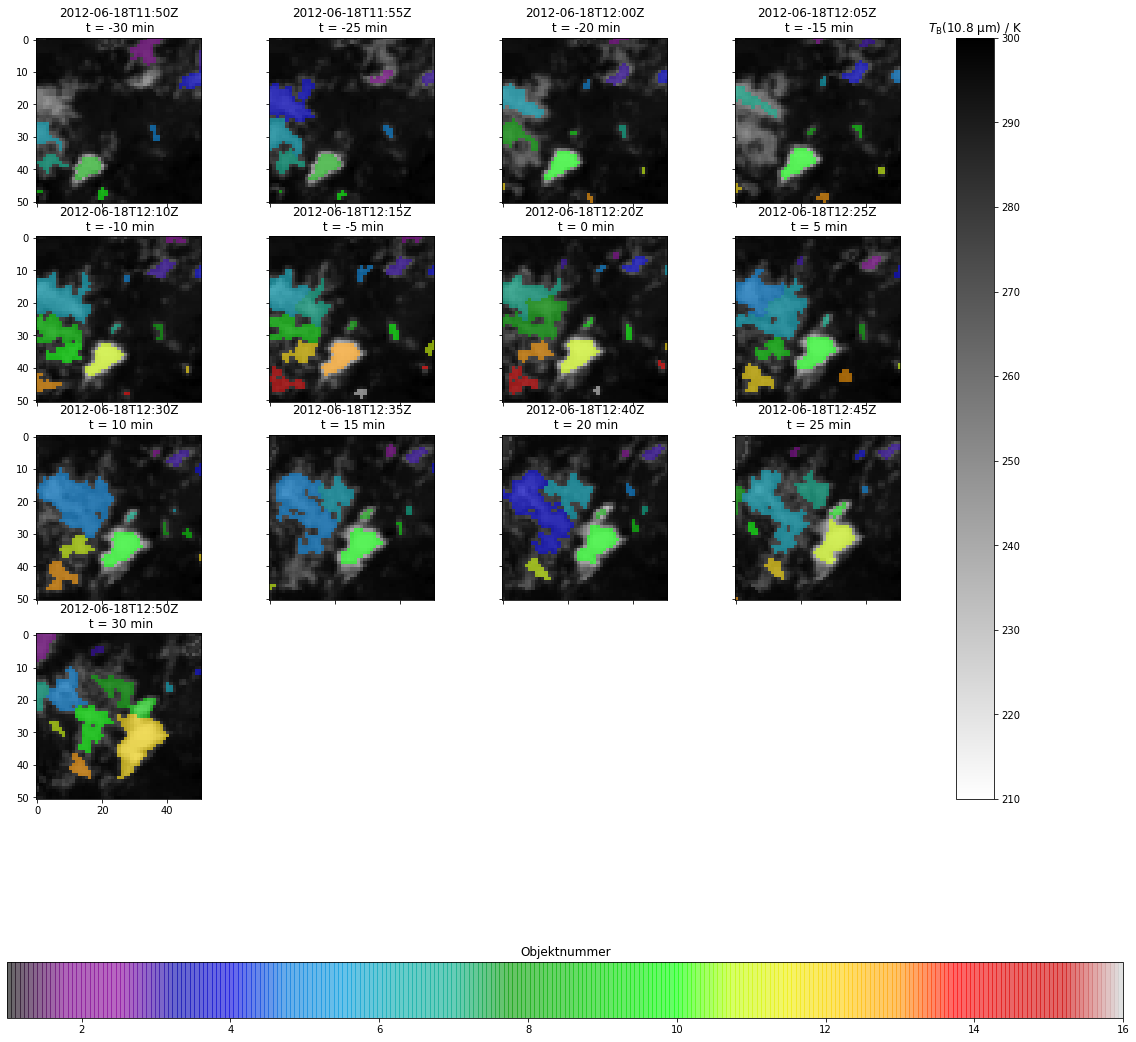

In [9]:
fig = plot_case_object(case,case_objects)

Das ist ein relativ isolierter Fall, auch wenn gegen Ende des Zeitausschnitts die Objekttrennung problematisch ist.

In [25]:
# Objekt, das zum Auslösungszeitpunkt am nächsten am HACI-Objektschwerpunkt liegt auswählen
object_id = ot.get_wanted_object_id(case_objects)
wanted_object_id = "{:03d}_{:04d}".format(len(case_objects)//2,object_id)

In [26]:
# Objekttrack auswählen, der dieses Objekt enthält
wanted_track = ot.select_wanted_track_from_list(case_tracks,wanted_object_id)

In [16]:
# alle anderen Objekte maskieren
wanted_object = ot.get_wanted_object_field(case_objects,wanted_track)

In [19]:
#fig = plot_case_object(case,np.array(list(wanted_object.values())))

In [20]:
# Objektwerte sammeln
values = ot.collect_object_values(case,wanted_object)

In [36]:
# Statistik der Objektwerte 
case_ir108_min = ot.aggregate_object_values(values,field='ir108',fraction=1,function='min')

In [62]:
object_area = []

values[(values.field=='ir108') & (values.time==-20)].field.size

2

In [57]:
ot.aggregate_object_values(values,field='ir108',fraction=1,function='mean')

[272.65415,
 270.147075,
 264.41264,
 262.8013666666667,
 257.71284,
 255.32489999999999,
 246.49496,
 240.7858285714286,
 230.89206666666666,
 229.95884166666664,
 243.49323142857148]

In [22]:
rx_filter = (values[values.field=='rx'].value <= -32.5) | (values[values.field=='rx'].value >= 92.5)

In [23]:
values[values.field=='rx'] = values[values.field=='rx'].replace([-32.5,92.5],0)

In [27]:
case_z_agg = ot.aggregate_object_values(values,field='rx',fraction=10,function='max')

In [51]:
#tidx = [int((v+30) //5)-((values.time.min()+30)//5) for v in values.time.unique()]

In [54]:
#tidx

<Figure size 864x432 with 0 Axes>

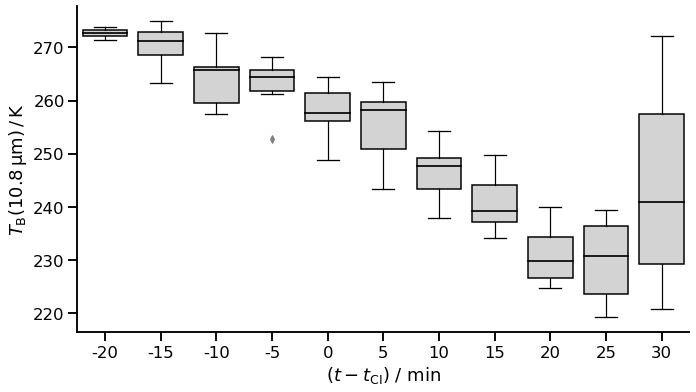

In [55]:
sns.set_context("talk")
plt.figure(figsize=(12,6))

sns.catplot(x='time',
            y='value',
            data=values[values['field']=='ir108'],
            kind='box',
            color='lightgray',
            boxprops = {'edgecolor': 'k',
                        'linewidth': 1.5},
            medianprops = {'color': 'k',
                           'linewidth': 1.7},
            whiskerprops = {'color': 'k', 
                            'linewidth': 1.2},
            capprops = {'color': 'k',
                        'linewidth': 1.3})
plt.xlabel(r"$\left(t - t_\mathrm{CI} \right)$ / min")
plt.ylabel(r"$T_\mathrm{B} (10.8\,$µm$)\,/\,\mathrm{K}$")
plt.gcf().set_size_inches(12, 6)

#plt.plot(tidx,case_ir108_min)

Das ergibt eine zu erwartende Lebenszykluskurve. Das Objekt kann 20&thinsp;min vor dem Auslösungszeitpunkt das erste mal definiert werden. Da ist es noch mit einer mittleren IR-10,8-µm-Helligkeitstemperatur von ca. 273&thinsp;K relativ warm und mit einer Fläche von 2 MSG-Pixeln relativ klein. Es wird dann mit der Zeit kälter

<Figure size 864x432 with 0 Axes>

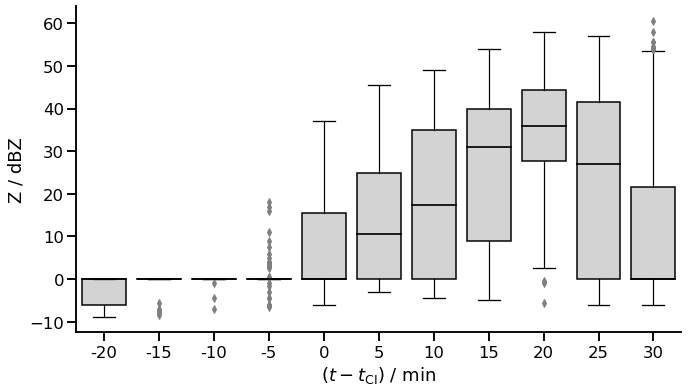

In [56]:
plt.figure(figsize=(12,6))

sns.catplot(x='time',
            y='value',
            data=values[values['field']=='rx'],
            kind='box',
            color='lightgray',
            boxprops = {'edgecolor': 'k',
                        'linewidth': 1.5},
            medianprops = {'color': 'k',
                           'linewidth': 1.7},
            whiskerprops = {'color': 'k', 
                            'linewidth': 1.2},
            capprops = {'color': 'k',
                        'linewidth': 1.3})
plt.xlabel(r"$\left(t - t_\mathrm{CI} \right)$ / min")
plt.ylabel("Z / dBZ")
plt.gcf().set_size_inches(12, 6)

#plt.plot(np.arange(0,13,1),case_z_agg)

OK, das ist ein Fall, wo nicht viel pasiert. Also eher keine Konvektion.

In [157]:
case = case_data[list(case_data.keys())[1]]

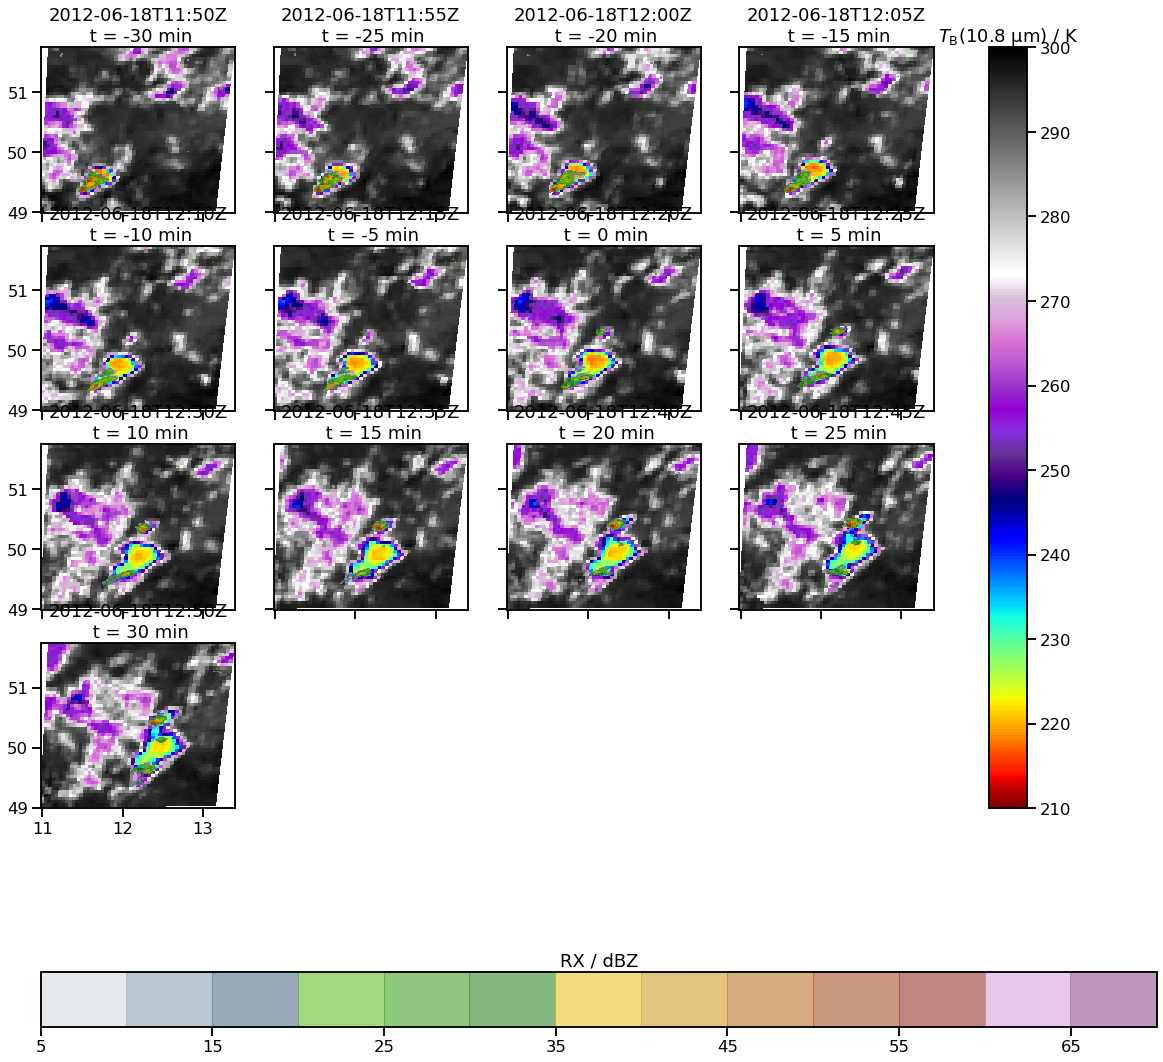

In [158]:
fig = plot_haci_case(case)

In [159]:
case_objects, case_tracks = ot.track_objects_lmin_cost(case,'ir108','wv073',minimum_depth=4,
                                                       tmin=220,tmax=273.15,tlevel=240,
                                                       spread=5,search_factor=5,smoothing_factor=1)

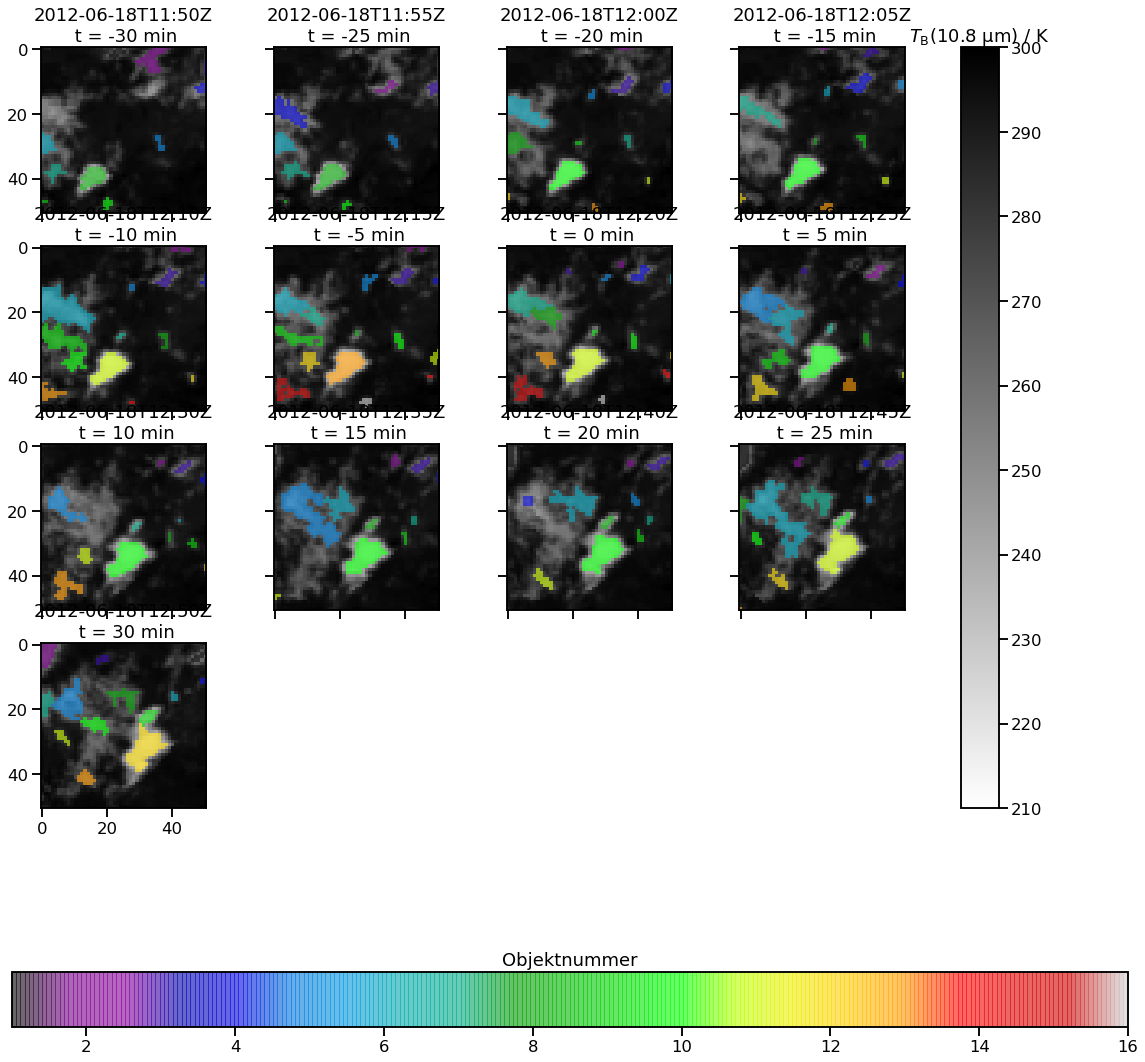

In [160]:
fig = plot_case_object(case,case_objects)

In [161]:
object_id = ot.get_wanted_object_id(case_objects)
wanted_object_id = "{:03d}_{:04d}".format(len(case_objects)//2,object_id)
wanted_track = ot.select_wanted_track_from_list(case_tracks,wanted_object_id)

In [ ]:
wanted_track

In [ ]:
wanted_object = ot.get_wanted_object_field(case_objects,wanted_track)

In [ ]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i,f in enumerate(case['ir108']):
    axs[i].imshow(f,vmin=210,vmax=300,cmap='gray_r')
    
    try:
        axs[i].imshow(np.ma.masked_less(wanted_object[i],1),cmap='Reds_r')
    except:
        continue

In [ ]:
from importlib import reload
reload(ot)

In [ ]:
object_values = ot.collect_object_values(case,wanted_object)

In [ ]:
obj_hrv = np.array(list(wanted_object.values())).repeat(3,axis=1).repeat(3,axis=2)

In [ ]:
data_array = case

In [ ]:
obj_hrv.shape

In [ ]:
import 

In [ ]:
# interpolate objects to RADOLAN grid
obj_hrv = dict()

#objects_hrv = dict()

for ohr in obj_hrv:
    obj_rx.append(ot.interpolate_grid(ohr,
                                  data_array['hlon'],
                                  data_array['hlat'],
                                  data_array['rlon'],
                                  data_array['rlat'],
                                  method='nearest'))

In [ ]:
np.array(obj_rx).shape

In [ ]:
# run through objects and collect values
values = []
times = []
field = []

for i in wanted_object.keys():
    #obj_hrv = objects[i].repeat(3,axis=0).repeat(3,axis=1)
    #obj_rx = interpolate_grid(obj_hrv,
    #                          data_array['hlon'],
    #                          data_array['hlat'],
    #                          data_array['rlon'],
    #                          data_array['rlat'],
    #                          method='nearest')

    object_locations = np.where(wanted_object[i]!=0)
    object_locations_hrv = np.where(obj_hrv[i]!=0)
    object_locations_rx = np.where(obj_rx[i]!=0)

    for f in list(data_array.keys())[:16]:
        if f == 'hrv':
            val = data_array[f][i][object_locations_hrv]
        elif f == 'rx':
            val = data_array[f][i][object_locations_rx]
        else:
            val = data_array[f][i][object_locations]

        values.extend(val.tolist())

        times.extend([(i*5)-30]*len(val))
        field.extend([f]*len(val))

# put everything into a data frame
collected_data = pd.DataFrame({'value':values,'time':times,'field':field})

In [ ]:
obj_hrv.shape

In [ ]:
object_values.field.unique()

<dic color="red">** collect object values muss noch repariert werden **</div>

In [ ]:
object_values

In [ ]:
case_ir108_agg = ot.aggregate_object_values(object_values,field='ir108',fraction=10,function='min')

In [ ]:
plt.figure(figsize=(12,6))

sns.catplot(x='time',
            y='value',
            data=object_values[object_values['field']=='ir108'],
            kind='box',
            color='lightgray',
            boxprops = {'edgecolor': 'k',
                        'linewidth': 1.5},
            medianprops = {'color': 'k',
                           'linewidth': 1.7},
            whiskerprops = {'color': 'k', 
                            'linewidth': 1.2},
            capprops = {'color': 'k',
                        'linewidth': 1.3})
plt.xlabel(r"$\left(t - t_\mathrm{CI} \right)$ / min")
plt.ylabel(r"$T_\mathrm{B} (10.8\,$µm$)\,/\,\mathrm{K}$")
plt.gcf().set_size_inches(12, 6)

plt.plot(np.arange(0,11,1),case_ir108_agg)

Es gibt hier dich eine Überlappung zwischen den Objekten in der Mitte.

Jetzt stimmts endlich.

In [ ]:
plt.plot(np.arange())

In [ ]:
from importlib import reload

In [ ]:
reload(ioc)

In [ ]:
haci_track_data_files = glob.glob("{}/*.csv".format(ioc.haci_case_data_path))

In [ ]:
len(haci_track_data_files)

In [ ]:
track_ids = ["{}_{}".format(cf.split("_")[-2],cf.split("_")[-1].split(".")[0]) for cf in haci_track_data_files]

In [ ]:
aggregated_data = {trid:{} for trid in sorted(track_ids)}

In [ ]:
cf = haci_track_data_files[5]

In [ ]:
data = pd.read_csv(haci_track_data_files[0])

In [ ]:
data.field.unique()

In [ ]:
data.field.unique()

In [ ]:
trid = "{}_{}".format(cf.split("_")[-2],cf.split("_")[-1].split(".")[0])
    
for data_field in data.field.unique():
    data_aggregated = ot.aggregate_object_values(data,field=data_field,
                                                 fraction=fun[data_field]['fraction'],
                                                 function=fun[data_field]['function'])

    aggregated_data[trid][data_field] = data_aggregated

In [ ]:
aggregated_data[trid]['time'] = data.time.unique()

In [ ]:
aggregated_data[trid]

In [ ]:
plt.plot(aggregated_data[trid]['time'],aggregated_data[trid]['ir108'])

In [ ]:
plt.plot(aggregated_data[trid]['time'],
         np.array(aggregated_data[trid]['ir087'])-np.array(aggregated_data[trid]['ir108']))

In [ ]:
test_agg = data[data['field']=='ir087']['value'].values - data[data['field']=='ir108']['value'].values

In [ ]:
tv = data[data['field']=='ir108']['time'].values

In [ ]:
tv

In [ ]:
plt.scatter(data[data['field']=='ir108']['time'].values, test_agg)
plt.plot(aggregated_data[trid]['time'],
         np.array(aggregated_data[trid]['ir087'])-np.array(aggregated_data[trid]['ir108']),color='red')

In [ ]:
data[data['field']=='ir087']

In [ ]:
fun = {'vis006': {'fraction':10,'function':'max'},
       'vis008': {'fraction':10,'function':'max'},
       'ir016':{'fraction':10,'function':'max'},
       'ir039':{'fraction':10,'function':'min'},
       'wv062':{'fraction':10,'function':'min'},
       'wv073':{'fraction':10,'function':'min'},
       'ir087':{'fraction':10,'function':'min'},
       'ir097':{'fraction':10,'function':'min'},
       'ir108':{'fraction':10,'function':'min'},
       'ir120':{'fraction':10,'function':'min'},
       'ir134':{'fraction':10,'function':'min'},
       'ct':{'fraction':100,'function':'median'},
       'ctth':{'fraction':100,'function':'max'},
       'cma':{'fraction':100,'function':'median'},
       'd_ir087_ir108':{'fraction':10,'function':'max'}, 
       'd_wv062_ir108':{'fraction':10,'function':'max'},
       'd_wv062_wv073':{'fraction':10,'function':'max'},
       'd_tri':{'fraction':10,'function':'max'},
       'rx':{'fraction':10, 'function':'max'},
       'hrv':{'fraction':10,'function':'max'}}

In [ ]:
coll_087_108 = data[data['field']=='ir087']['value'].values - data[data['field']=='ir108']['value'].values
val_len = len(coll_087_108)
coll_087_108_df = pd.DataFrame({'value':coll_087_108,
                                'time':data[data['field']=='ir108'].time.values,
                                'field':['d_ir087_ir108']*val_len})
aggregated_data[trid]['d_ir087_ir108'] = ot.aggregate_object_values(coll_087_108_df,
                                                                    field='d_ir087_ir108',
                                                                    function='max')
data = data.append(coll_087_108_df)

In [ ]:
trid

In [ ]:
aggregated_data[trid]['d_ir087_ir108']

In [ ]:
coll_062_108 = data[data['field']=='wv062']['value'].values - data[data['field']=='ir108']['value'].values
val_len = len(coll_062_108)
coll_062_108_df = pd.DataFrame({'value':coll_062_108,
                                'time':data[data['field']=='ir108'].time.values,
                                'field':['d_wv062_ir108']*val_len})
aggregated_data[trid]['d_wv062_ir108'] = ot.aggregate_object_values(coll_062_108_df,
                                                                    field='d_wv062_ir108',
                                                                    function='max')
data = data.append(coll_062_108_df)
    
coll_062_073 = data[data['field']=='wv062']['value'].values - data[data['field']=='wv073']['value'].values
val_len = len(coll_062_073)
coll_062_073_df = pd.DataFrame({'value':coll_062_073,
                                'time':data[data['field']=='wv073'].time.values,
                                'field':['d_wv062_wv073']*val_len})
aggregated_data[trid]['d_wv062_wv073'] = ot.aggregate_object_values(coll_062_073_df,
                                                                    field='d_wv062_wv073',
                                                                    function='max')
data = data.append(coll_062_073_df)

coll_tri = (data[data['field']=='ir087']['value'].values - data[data['field']=='ir108']['value'].values) - (data[data['field']=='ir108']['value'].values - data[data['field']=='ir120']['value'].values)
val_len = len(coll_tri)
coll_tri_df = pd.DataFrame({'value':coll_tri,
                            'time':data[data['field']=='ir108'].time.values,
                            'field':['d_tri']*val_len})
aggregated_data[trid]['d_tri'] = ot.aggregate_object_values(coll_tri_df,
                                                            field='d_tri',
                                                            function='max')
data = data.append(coll_tri_df)

In [ ]:
aggregated_data[trid]

In [162]:
def aggregate_data2frame(data):
    agg = {}
    for data_field in data.field.unique():
            data_aggregated = ot.aggregate_object_values(data,field=data_field,
                                                         fraction=fun[data_field]['fraction'],
                                                         function=fun[data_field]['function'])

            agg[data_field] = data_aggregated

    # Zeitschritte
    agg['time'] = data['time'].unique()

    agg_df = pd.DataFrame(agg)
    
    return agg_df

In [167]:
fun = {'vis006': {'fraction':10,'function':'max'},
       'vis008': {'fraction':10,'function':'max'},
       'ir016':{'fraction':10,'function':'max'},
       'ir039':{'fraction':10,'function':'min'},
       'wv062':{'fraction':10,'function':'min'},
       'wv073':{'fraction':10,'function':'min'},
       'ir087':{'fraction':10,'function':'min'},
       'ir097':{'fraction':10,'function':'min'},
       'ir108':{'fraction':10,'function':'min'},
       'ir120':{'fraction':10,'function':'min'},
       'ir134':{'fraction':10,'function':'min'},
       'ct':{'fraction':100,'function':'median'},
       'ctth':{'fraction':100,'function':'max'},
       'cma':{'fraction':100,'function':'median'},
       'd_ir087_ir108':{'fraction':10,'function':'max'}, 
       'd_wv062_ir108':{'fraction':10,'function':'max'},
       'd_wv062_wv073':{'fraction':10,'function':'max'},
       'd_tri':{'fraction':10,'function':'max'},
       'rx':{'fraction':10, 'function':'max'},
       'hrv':{'fraction':10,'function':'max'}}

In [165]:
haci_track_data_files = glob.glob("{}/*.csv".format(ioc.haci_case_data_path))

In [ ]:
for df in tqdm.tqdm(haci_track_data_files):
    data = pd.read_csv(df)
    
    data[data.field=='rx'] = data[data.field=='rx'].replace([-32.5,92.5],0)
    
    agg_df = aggregate_data2frame(data)
    
    trid = "{}_{}".format(df.split("_")[-2],df.split("_")[-1].split(".")[0])
    agg_df.to_csv("{}/HACI_object_data/object_data_{}.csv".format(local_data_path,trid),index=False, float_format="%.2f")

 92%|█████████▏| 3175/3463 [1:13:00<06:15,  1.31s/it]

In [ ]:
data[data.field=='rx']